# **Movie genre prediction using multi-modal deep learning - pre-processing data**

This notebook involves downloading the dataset from kaggle and picking the relevant features to make the train, test and validation sets. It also involves downloading movie posters using the TMDB API.

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

 92% 210M/228M [00:03<00:00, 49.5MB/s]
100% 228M/228M [00:03<00:00, 65.0MB/s]


In [0]:
!unzip /content/the-movies-dataset.zip

Archive:  /content/the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
style.use('seaborn-poster')
style.use('ggplot')

In [0]:
data = pd.read_csv("/content/movies_metadata.csv")
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Picking out the title, overview, genres and movie id from the original csv. The ID was picked to find the exact movie poster on TMDB to download.

In [0]:
filtered_data = data.filter(['original_title','overview', 'id', 'genres'], axis=1)
len(filtered_data)

45466

In [0]:
genres = filtered_data['genres'].tolist()

Some genres seem to occur only once in the entire dataset. Hence, we remove those. In addition to this, genres like "TV Movie" and "Foreign" are not easily percieved from posters and movie summaries. Hence, those were removed as well.

In [0]:
genre_per_movie = []
genre_dict = {}
invalid_genres = ['Aniplex', 'BROSTA TV', 'Carousel Productions', 'GoHands',
                  'Mardock Scramble Production Committee', 'Odyssey Media',
                  'Pulser Productions', 'Rogue State', 'Sentai Filmworks',
                  'Telescene Film Group Productions', 'The Cartel', 'Vision View Entertainment', 
                  'TV Movie', 'Foreign']
for genre in genres:
  genre = ast.literal_eval(genre)
  genre_list = []
  for val in genre:
    if val['name'] not in invalid_genres:
      genre_list.append(val['name'])
      if val['name'] in genre_dict:
        genre_dict[val['name']] += 1
      else:
        genre_dict[val['name']] = 1
  genre_per_movie.append(genre_list)

genre_dict = {key:val for key, val in genre_dict.items() if val != 1}
genre_dict

{'Action': 6596,
 'Adventure': 3496,
 'Animation': 1935,
 'Comedy': 13182,
 'Crime': 4307,
 'Documentary': 3932,
 'Drama': 20265,
 'Family': 2770,
 'Fantasy': 2313,
 'History': 1398,
 'Horror': 4673,
 'Music': 1598,
 'Mystery': 2467,
 'Romance': 6735,
 'Science Fiction': 3049,
 'Thriller': 7624,
 'War': 1323,
 'Western': 1042}

In [0]:
len(genre_per_movie)

45466

In [0]:
keys = list(genre_dict.keys())
values = list(genre_dict.values())

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text major ticklabel objects>)

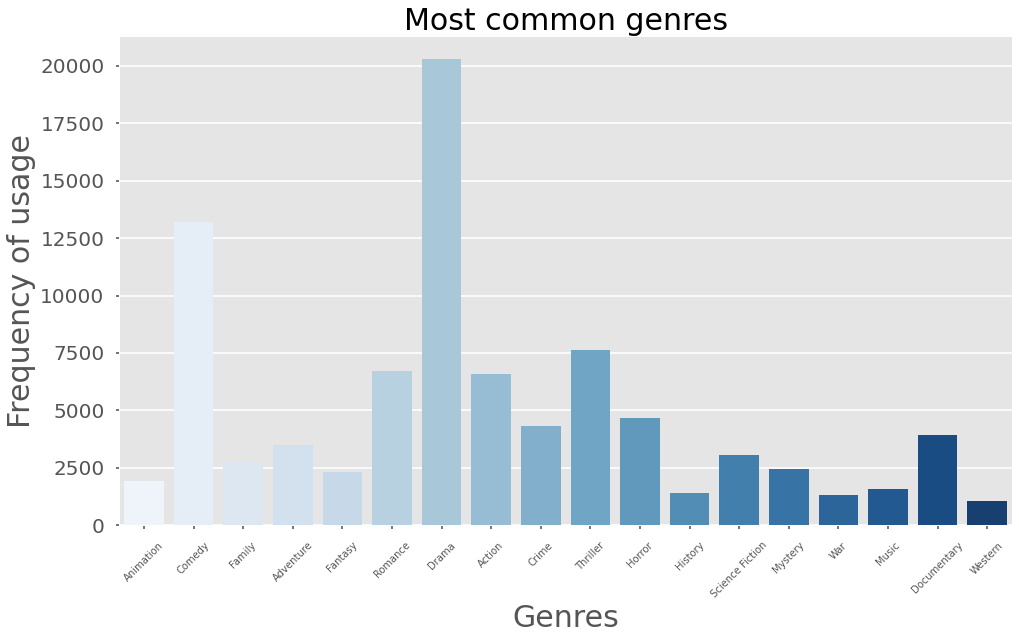

In [0]:
plt.figure(figsize=(16, 9))
sns.barplot(keys, values, palette=("Blues"))
plt.title("Most common genres", size=30)
plt.ylabel('Frequency of usage', size=30)
plt.xlabel('Genres', size=30)
plt.xticks(size=10)
plt.xticks(rotation=45)
plt.yticks(size=20)

In [0]:
filtered_data['genre_list'] = genre_per_movie
filtered_data.head()

,original_title,overview,id,genres,genre_list
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]"
1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]"
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",[Comedy]


Removing any rows where the genres column in empty


In [0]:
filtered_data = filtered_data[filtered_data['genre_list'].map(lambda d: len(d)) > 0]
len(filtered_data)

42995

In [0]:
total_empty = 0
for genre in genre_per_movie:
  if not len(genre):
    total_empty += 1

total_empty

2471

In [0]:
from bs4 import BeautifulSoup
import requests
import os

I used the tmdbv3api for Python to download posters.

In [0]:
!pip install tmdbv3api

In [0]:
from tmdbv3api import TMDb
from tmdbv3api import Movie
tmdb = TMDb()
tmdb.api_key = 'Your API key'

A utility function to download and save posters. In case the movie ID is not found or does not have a poster, an error is appended as the poster path. After all posters are downloaded the respective poster_paths are appended to the dataset.

In [0]:
def get_posters(url, name):
  try:
    baseurl = 'http://image.tmdb.org/t/p/w185'
    link = baseurl + url
    img = requests.get(link).content
    name = name.replace('/', '_')
    file_name = str(name) + ".jpg"
    path = os.path.join('/content/drive/My Drive/Movie_genre_prediction_dataset/downloaded_posters', file_name)
    with open(path, 'wb') as handler:
      handler.write(img)
    return path
  except Exception as e:
    print('[ERROR]', str(e))
    return "Error"

In [0]:
poster_paths = []
movie = Movie()

i = 1
for id, name in zip(filtered_data['id'].tolist(), filtered_data['original_title'].tolist()):
  m = movie.details(int(id))
  print('Downloading:', name, "i", i)
  try:
    poster_paths.append(get_posters(m.poster_path, name))
  except Exception as e:
    print('[ERROR]', str(e))
    poster_paths.append("API Error")
  i += 1
  # temp = name.replace('/', '_')
  # file_name = str(temp) + ".jpg"
  # path = os.path.join('/content/drive/My Drive/Movie_genre_prediction_dataset/downloaded_posters', file_name)
  # if '/' in name:
  #   print(name)
  #   print("Path:", path)

print(len(poster_paths))

In [0]:
filtered_data['poster_paths'] = poster_paths
filtered_data.head()

,original_title,overview,id,genres,genre_list,poster_paths
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]",/content/drive/My Drive/Movie_genre_prediction...
1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]",/content/drive/My Drive/Movie_genre_prediction...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]",/content/drive/My Drive/Movie_genre_prediction...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]",/content/drive/My Drive/Movie_genre_prediction...
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",[Comedy],/content/drive/My Drive/Movie_genre_prediction...


Removing all rows where the poster_paths are invalid.

In [0]:
print(len(filtered_data))
print(len(filtered_data[(filtered_data['poster_paths'] == "API Error") | (filtered_data['poster_paths'] == "Error")]))

42995
5674


In [0]:
filtered_data = filtered_data[filtered_data['poster_paths'] != "API Error"]
print(len(filtered_data))

42682


In [0]:
filtered_data = filtered_data[filtered_data['poster_paths'] != "Error"]
print(len(filtered_data))

37321


In [0]:
filtered_data.head()

,original_title,overview,id,genres,genre_list,poster_paths
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[Animation, Comedy, Family]",/content/drive/My Drive/Movie_genre_prediction...
1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[Adventure, Fantasy, Family]",/content/drive/My Drive/Movie_genre_prediction...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[Romance, Comedy]",/content/drive/My Drive/Movie_genre_prediction...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[Comedy, Drama, Romance]",/content/drive/My Drive/Movie_genre_prediction...
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",[Comedy],/content/drive/My Drive/Movie_genre_prediction...


In [0]:
filtered_data.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/dataset_mod.csv")

In [0]:
filtered_data = pd.read_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/dataset_mod.csv")

In [0]:
filtered_data.head()

,Unnamed: 0,original_title,overview,id,genres,genre_list,poster_paths
0,0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",/content/drive/My Drive/Movie_genre_prediction...
1,1,Jumanji,When siblings Judy and Peter discover an encha...,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",/content/drive/My Drive/Movie_genre_prediction...
2,2,Grumpier Old Men,A family wedding reignites the ancient feud be...,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",/content/drive/My Drive/Movie_genre_prediction...
3,3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",/content/drive/My Drive/Movie_genre_prediction...
4,4,Father of the Bride Part II,Just when George Banks has recovered from his ...,11862,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],/content/drive/My Drive/Movie_genre_prediction...


Splitting the data into training, testing and validation sets.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(filtered_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.1)
print(type(train), type(test), type(val))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [0]:
val.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/val_data.csv")
test.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/test_data.csv")
train.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/train_data.csv")

### Downloading posters

I used the TMBD API to download posters by searching for the movie using the movie ID given in the original database. All downloaded images are then read, resized and their pixels normalized between 0 and 1. Each image is then appended to a list. In case any images are not readable, those rows are dropped. The list of images obtained for the train, test and validation datasets are then saved as numpy arrays. This was done to easily load them later as an input to the model.

In [0]:
import cv2

def resize_img(path):
  try:
    img = cv2.imread(path)
    img = cv2.resize(img, (75, 115))
    img = img.astype(np.float32)/255
    return img
  except Exception as e:
    print(str(e))
    return None

In [0]:
val_imgs = []
i = 0
for index, row in val.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['poster_paths']))
  img = resize_img(str(row['poster_paths']))
  if img is not None:
    val_imgs.append(img)
  else:
    val = val.drop(index)
    print("Dropping row:", index, "Length:", len(val))
  i += 1

In [0]:
assert len(val) == len(val_imgs)

In [0]:
val_np_imgs = np.array(val_imgs)
val_np_imgs.shape

(2986, 115, 75, 3)

In [0]:
val.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/val_data.csv")

In [0]:
import pickle
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/val_np_img_norm','wb') as f: pickle.dump(val_np_imgs, f)

In [0]:
test_imgs = []
i = 0
for index, row in test.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['poster_paths']))
  img = resize_img(str(row['poster_paths']))
  if img is not None:
    test_imgs.append(img)
  else:
    test = test.drop(index)
    print("Dropping row:", index, "Length:", len(test))
  i += 1

In [0]:
assert len(test) == len(test_imgs)

In [0]:
test_np_imgs = np.array(test_imgs)
test_np_imgs.shape

(7463, 115, 75, 3)

In [0]:
test.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/test_data.csv")

In [0]:
import pickle
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/test_np_imgs_norm','wb') as f: pickle.dump(test_np_imgs, f)

In [0]:
train_imgs = []
i = 0
for index, row in train.iterrows():
  if i%100 == 0:
    print("Processing i:", i, str(row['poster_paths']))
  img = resize_img(str(row['poster_paths']))
  if img is not None:
    train_imgs.append(img)
  else:
    train = train.drop(index)
    print("Dropping row:", index, "Length:", len(train))
  i += 1

In [0]:
assert len(train) == len(train_imgs)

In [0]:
train_np_imgs = np.array(train_imgs)
train_np_imgs.shape

(26864, 115, 75, 3)

In [0]:
train.to_csv("/content/drive/My Drive/Movie_genre_prediction_dataset/train_data.csv")

In [0]:
import pickle
with open('/content/drive/My Drive/Movie_genre_prediction_dataset/train_np_imgs_norm','wb') as f: pickle.dump(train_np_imgs, f)